## 卷积层实现

PyTorch 中，既可以通过自定义权值的底层实现方式搭建神经网络，也可以直接调用现成的卷积层类的高层方式快速搭建复杂网络。我们主要以 2D 卷积为例，介绍如何实现卷积神经网络层。


#### 1 自定义权值

在PyTorch中，通过F.conv2d 函数可以方便地实现2D卷积运算。F.conv2d 基于输入𝑿:[b, 𝑐𝑖𝑛, ℎ, 𝑤]和卷积核𝑾: [𝑐𝑜𝑢𝑡, 𝑐𝑖𝑛, 𝑘, 𝑘] 进行卷积运算，得到输出𝑶: [b, 𝑐𝑜𝑢𝑡, ℎ′ 𝑤′] ，其中𝑐𝑖𝑛表示输入通道数，𝑐𝑜𝑢𝑡表示卷积核的数量，也是输出特征图的通道数。


In [2]:
# 导入库
import torch
import torch.nn as nn
from torch.nn import functional as F

In [3]:
# 模拟输入，2个batch，3 通道，高宽为 5
x = torch.randn([2, 3, 5, 5])

# 需要根据[cout, cin, k, k]格式创建W张量，4个 3x3 大小卷积核
w = torch.randn([4, 3, 3, 3])

# 步长为 1, padding 为 0,
out = F.conv2d(x, w, bias=None, stride=1, padding=(0,0))

print('out:', out.shape)


out: torch.Size([2, 4, 3, 3])


其中 padding 参数的设置格式为：padding=[padding_H,padding_W].此外，padding 参数还可以设定为”valid”，表示无 padding。例如，上下左右各填充一个单位，则 padding参数设置为 ，实现如下：

In [4]:
# 模拟输入，2个batch，3 通道，高宽为 5
x = torch.randn([2, 3, 5, 5])
# 需要根据[cout, cin, k, k]格式创建 W 张量，4 个 3x3 大小卷积核
w = torch.randn([4, 3, 3, 3])
# 步长为 1, padding 为 1,
out = F.conv2d(x, w, bias=None, stride=1, padding=(1,1))
print('out:', out.shape)

out: torch.Size([2, 4, 5, 5])


特别地，通过设置参数 padding='same'、stride=1 可以直接得到输入、输出同大小的卷积层，其中 padding 的具体数量由 PyTorch 自动计算并完成填充操作。例如：


In [5]:
# 模拟输入，3 通道，高宽为 5
x = torch.randn([2, 3, 5, 5])
# 需要根据[cout, cin, k, k]格式创建 W 张量，4 个 3x3 大小卷积核
w = torch.randn([4, 3, 3, 3])
# 步长为 1, padding 为 0,
out = F.conv2d(x, w, bias=None, stride=1, padding='same')
print('out:', out.shape)

out: torch.Size([2, 4, 5, 5])


卷积神经网络层与全连接层一样，可以设置网络带偏置向量。F.conv2d 函数可以通过设置bias参数实现，添加偏置只需要手动累加偏置张量即可。例如：

In [6]:
# 根据[cout, 1, 1]格式创建偏置向量(张量)
b = torch.zeros([4, 1, 1])
# 在卷积输出上叠加偏置向量，它会自动 broadcasting 为[b,cout,h',w']
out = out + b
print('out:', out.shape)

out: torch.Size([2, 4, 5, 5])


#### 2 卷积层类

通过卷积层类 nn.Conv2d 可以不需要手动定义卷积核𝑾和偏置𝒃张量，直接调用类实例即可完成卷积层的前向计算，实现更加高层和快捷。在 PyTorch 中，API 的命名有一定的规律，首字母大写的对象一般表示类，全部小写的一般表示函数，如 nn.Conv2d 表示卷积层类，F.conv2d 表示卷积运算函数。使用类方式会在创建类实例时自动创建需要的权值张量和偏置向量等，用户不需要记忆卷积核张量的定义格式，因此使用起来更简单方便，但是灵活性也略低。函数方式的接口需要自行定义权值和偏置等，更加底层和灵活。

在新建卷积层类时，只需要指定输入通道数 in_channels，卷积核数量(或输入通道数)out_channels，卷积核大小kernel_size，步长 stride，填充 padding 等即可。如下创建了4个3 × 3大小的卷积核的卷积层，输入通道数为 3，步长为 1，padding方案'same'：

In [7]:
layer = nn.Conv2d(3, 4, kernel_size=3, stride=1, padding='same') # 3输入通道数，4是卷积核数量.

如果卷积核高宽不等，步长行列方向不等，此时需要将 kernel_size参数设计为tuple格式(𝑘ℎ 𝑘𝑤)，strides 参数设计为(𝑠ℎ 𝑠𝑤)。如下创建4个3×3大小的卷积核，竖直方向移动步长𝑠ℎ = 2，水平方向移动步长𝑠𝑤 =1：

In [8]:
layer = nn.Conv2d(3, 4, kernel_size=(3,4), stride=(2,1), padding='valid')


In [9]:
# 创建卷积层类
layer = nn.Conv2d(3, 4, kernel_size=3, stride=1, padding='same')
# 前向计算
out = layer(x)
print('out:', out.shape)

out: torch.Size([2, 4, 5, 5])


在类 Conv2d 中，保存了卷积核张量𝑾和偏置𝒃，可以通过类成员 named_parameters函数或parameters 函数直接返回𝑾和𝒃的列表。例如：


In [9]:

for name,p in layer.named_parameters():
    print(name, p.shape)

weight torch.Size([4, 3, 3, 3])
bias torch.Size([4])


In [10]:
layer = nn.Conv2d(3, 4, kernel_size=(3,4), stride=(2,1), padding='valid')
for name,p in layer.named_parameters():
    print(name, p.shape)

weight torch.Size([4, 3, 3, 4])
bias torch.Size([4])


通过调用 parameters 可以返回 Conv2D 类维护的𝑾和𝒃张量，这个类成员在获取网络层的待优化变量时非常有用。也可以直接调用类实例 layer.weight、layer.bias 名访问𝑾和𝒃张量。


#### LeNet-5 实验

LeNet-5 的网络结构图如下，它接受32 × 32大小的数字、字符图片，经过第一个卷积层得到[b,28, 28, 6]形状的张量，经过一个向下采样层，张量尺寸缩小到[b,14, 14, 6]，经过第二个卷积层，得到形状[b,10, 10, 16]的张量，同样经过下采样层，张量尺寸缩小到[b,5, 5, 16] ，在进入全连接层之前，先将张量打成[b,400]的张量，送入输出节点数分别为 120、84 的 2 个全连接层，得到[b 84]的张量，最后通过 Gaussian connections 层.网络结构图如下：

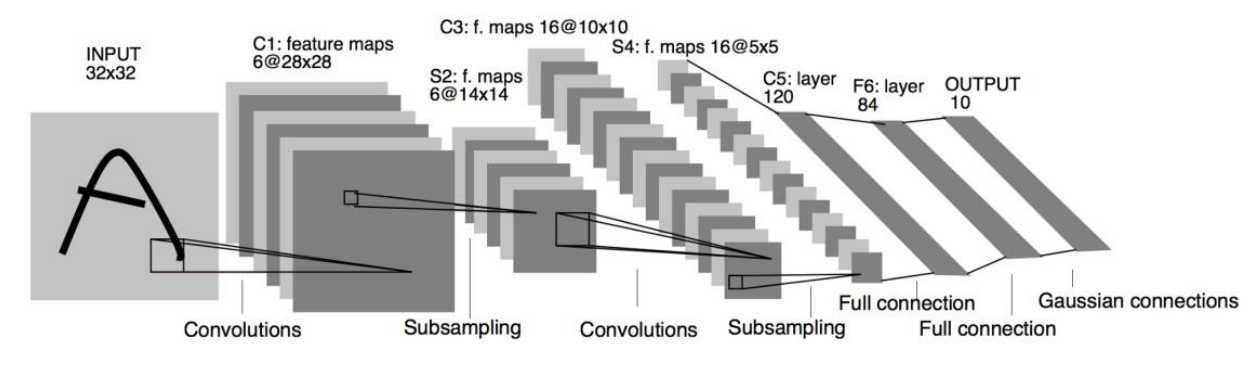

本实验在LeNet-5的基础上进行了少许调整，使得它更容易在现代深度学习框架上实现。首先我们将输入𝑿形状由32 × 32调整为28 × 28，然后将 2 个下采样层实现为最大池化
层，最后利用全连接层替换掉 Gaussian connections层。以后统一称修改的网络也为 LeNet-5 网络。网络结构图如图下所示：

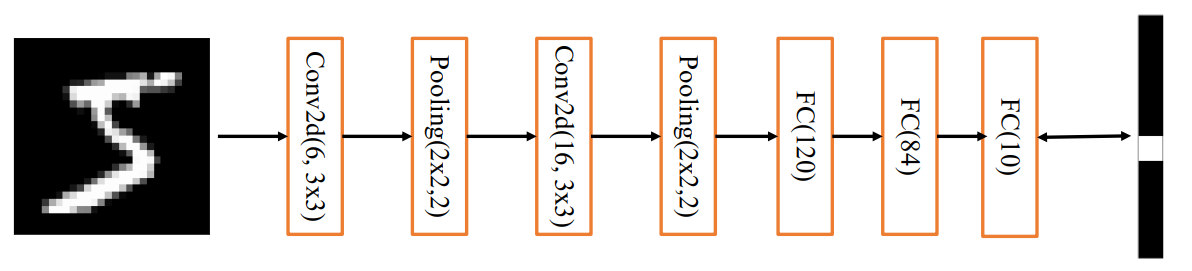

通过Sequential容器创建 LeNet-5，代码如下：

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch import nn, optim

In [11]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__() 
        # 网络容器
        self.model = nn.Sequential(
            # 第一个卷积层, 6 个 3x3 卷积核
            nn.Conv2d(1, 6, kernel_size=3, stride=1),
            # 高宽各减半的池化层
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(), # 激活函数
            # 第二个卷积层, 16 个 3x3 卷积核
            nn.Conv2d(6, 16, kernel_size=3, stride=1),
            # 高宽各减半的池化层
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(), # 激活函数
            # 打平层，方便全连接层输入
            nn.Flatten(),
            nn.Linear(400, 120),# 全连接层，120 个节点
            nn.ReLU(),
            nn.Linear(120, 84),# 全连接层，84 节点
            nn.ReLU(),
            nn.Linear(84, 10),# 全连接层，10 个节点
           )
    def forward(self, x):
        # 前向计算过程
        x = self.model(x)
        return x

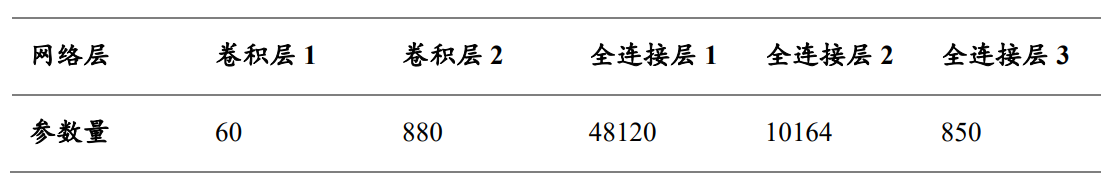

In [12]:
# 设置批大小
batchsz = 32

# 在线下载 MNIST 数据集，并保存到 mnist_data 文件夹
train_db = datasets.MNIST('mnist_data', True, 
transform=transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
    ]), download=True)
    
train_loader = DataLoader(train_db, batch_size=batchsz, shuffle=True)

val_db = datasets.MNIST('mnist_data', False, 
transform=transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
    ]), download=True)
    
val_loader = DataLoader(val_db, batch_size=batchsz, shuffle=False)

# 加载一个 batch，并查看数据
x, label = iter(train_loader).next()
print('x:', x.shape, 'label:', label.shape)


x: torch.Size([32, 1, 28, 28]) label: torch.Size([32])


In [13]:
# 创建网络模型
device = torch.device('cuda')
model = LeNet5().to(device) 
print(model) # 打印模型结构


LeNet5(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [14]:
# 创建 loss 函数
criteon = nn.CrossEntropyLoss().to(device)
# 创建优化器，学习率 lr=0.0001
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [15]:
# 训练 100 个 epoch
for epoch in range(20):
    # 模型切换到 train 模式
    model.train()
    for step, (x, label) in enumerate(train_loader):
        # x 张量:[b, 1, 32, 32]
        # label 张量:[b]
        x, label = x.to(device), label.to(device)
        # 前向传播
        logits = model(x)
        # logits: [b, 10]
        # label: [b]
        # 计算 Loss 损失值，标量
        loss = criteon(logits, label)
        # 清零梯度，反向传播，并更新梯度
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 打印 loss 值    
    print(epoch, 'loss:', loss.item())


0 loss: 0.2558749318122864
1 loss: 0.28415656089782715
2 loss: 0.148596853017807
3 loss: 0.22047936916351318
4 loss: 0.0353238508105278
5 loss: 0.036452751606702805
6 loss: 0.033343397080898285
7 loss: 0.07946717739105225
8 loss: 0.034182965755462646
9 loss: 0.03614051640033722
10 loss: 0.03249932453036308
11 loss: 0.03713858127593994
12 loss: 0.04418589547276497
13 loss: 0.00598421785980463
14 loss: 0.01061286497861147
15 loss: 0.09742195159196854
16 loss: 0.003067553509026766
17 loss: 0.034925393760204315
18 loss: 0.06892824918031693
19 loss: 0.012953187339007854


In [16]:
# 切换到测试模式
model.eval()
# 构建无梯度环境
with torch.no_grad(): 
    total_correct = 0 # 统计正确样本数量
    total_num = 0 # 统计总样本数量
    for x, label in val_loader: 
        x, label = x.to(device), label.to(device) 
        # 前向计算，获得 10 类别的预测分布，[b,1,28,28] => [b, 10]
        logits = model(x)
        # 标准的流程需要先经过 softmax，再 argmax
        # 但是由于 softmax 不改变元素的大小相对关系，故可省去
        pred = logits.argmax(dim=1)
        # 统计预测正确数量
        correct = torch.eq(pred, label).float().sum().item()
        total_correct += correct
        # 统计预测样本总数
        total_num += x.size(0) 
    # 计算准确率
    acc = total_correct / total_num
    print(epoch, 'acc:', acc)

19 acc: 0.9867


以 LeNet-5 的网络模型为例，在卷积层后添加 BN 层，代码如下：